# Predicting Death in COVID19

## Data Loading

In [212]:
from numpy.random import seed
seed(2)

import os
import errno
import pickle
import sys
import pandas as pd
import numpy as np
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support, classification_report

In [213]:
import keras
from keras.models import Model, Input, load_model, Sequential
from keras.layers import Masking, Flatten, Embedding, Dense, LSTM, TimeDistributed, Reshape, multiply, Permute, Lambda
from keras.optimizers import RMSprop, Adam

In [214]:
df = pd.read_csv('covid.csv')

In [215]:
# convert gender to 0 or 1
df['GENDER'] = (df['GENDER'] == 'Male').astype(int)

In [216]:
def df_split(df, ratio=0.3):
    '''
    Given dataframe, split 20% of patients into a separate test dataframe.
    Return df_train, df_test
    '''
    num_hadms = len(df['HADM_ID'].unique())
    split = int(ratio * num_hadms)
    hadms = df['HADM_ID'].unique()[:split]
    
    return df[~df.HADM_ID.isin(hadms)], df[df.HADM_ID.isin(hadms)]

df_train, df_test = df_split(df)

In [217]:
# sanity check
df_test['HADM_ID'].isin(df_train['HADM_ID']).value_counts()

False    642
Name: HADM_ID, dtype: int64

In [218]:
df_train['HADM_ID'].isin(df_test['HADM_ID']).value_counts()

False    1796
Name: HADM_ID, dtype: int64

In [219]:
X_cols = [
    "Creatinine", "Haemoglobin", "Platelet_count",
    "AGE", "GENDER",
    'Chronic Kidney Disease', 'Obesity', 'Heart disease', 'Asthma', #comorbidities
    'Weight_kg', 'SaO2', 
    'pH', 'glucose', 'systolic_pressure','diastolic_pressure', 'blood_urea_nitrogen'
]

In [220]:
def create_tensors(df, maxshape=(0,0)):
    '''
    Split dataframe into X and Y tensors.

    Return X, Y
    '''
    hadms = df['HADM_ID'].unique()
    
    lst = []
    lst_y = []
    
    for hadm in hadms:
        point = df[df.HADM_ID == hadm][X_cols]
        maxshape = max(maxshape, point.values.shape)
        
        # for now, try with data only 48hours prior
#         if len(point.values) > 2:
#             point = point[:-2]
            
        lst.append(point.values)
        lst_y.append(df[df.HADM_ID == hadm]['DEATH'].iloc[0])
    
    # pad to max shape to create tensor
    ret = np.zeros((len(lst), *maxshape))
    
    ret_y = np.array(lst_y)
    
    for index, l in enumerate(lst):
        x, y = min(maxshape[0], l.shape[0]), l.shape[1]

        ret[index, :x, :y] = l[:x, :y]

    return lst, ret, ret_y

lst_train, X_train, Y_train = create_tensors(df_train)
lst_test, X_test, Y_test = create_tensors(df_test)

In [221]:
X_train.shape

(213, 43, 16)

## Dataset

### Histogram of Days

Don't cut to 14 days - want last day data before death for now

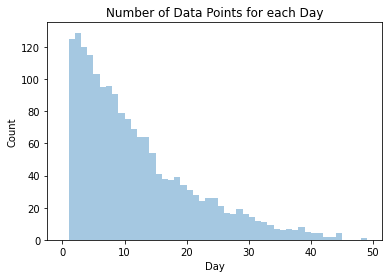

In [222]:
fig = sns.distplot(df_train[df_train.Day < 50]['Day'], bins=range(50), kde=False)
plt.title('Number of Data Points for each Day')
plt.ylabel('Count')
plt.show(fig)

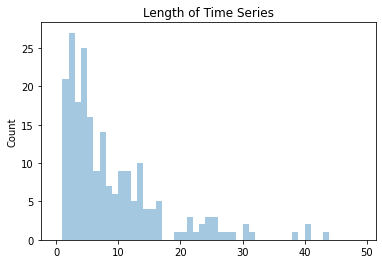

In [223]:
fig = sns.distplot([len(x) for x in lst_train if len(x) <= 50], bins=range(50), kde=False)
plt.title('Length of Time Series')
plt.ylabel('Count')
plt.show(fig)

In [224]:
# summary statistics
df_train['Day'].describe()

count    1796.000000
mean       11.445991
std         9.527493
min         1.000000
25%         4.000000
50%         9.000000
75%        16.000000
max        99.000000
Name: Day, dtype: float64

In [225]:
# number of patients who died
df_train.groupby('HADM_ID').first()['DEATH'].value_counts()

0.0    107
1.0    106
Name: DEATH, dtype: int64

In [226]:
1 - sum(Y_test) / len(Y_test)

0.5555555555555556

In [227]:
# class weights
class_weight = {0: 1, 1: 1}

### Histogram of Outcomes for Each Feature
We want to see the distributions for each different numeric feature. This is best done as a histogram. You can see all of these histograms below.

HCO3, Age and Heart Rate appear to be the most separable. 

In [228]:
def plot_feature(col):
    died = []
    discharged = []

    for index, point in enumerate(lst_train):        
        if Y_train[index]:
            died.append(point[0, X_cols.index(col)])
        else:
            discharged.append(point[0, X_cols.index(col)])

    minimum = min(*died,*discharged)
    maximum = max(*died,*discharged)
    
    if minimum == 0 and maximum == 1:
        return
    
    bins = np.linspace(minimum, maximum, num=20)
            
    sns.distplot(discharged, kde=False, bins=bins, label="Discharged")
    fig = sns.distplot(died, kde=False, bins=bins, label="Died")
    plt.title(f'Histogram for {col.title()}')
    plt.ylabel('Count')
    plt.xlabel(str(col.title()))
    plt.legend()
    plt.show(fig)

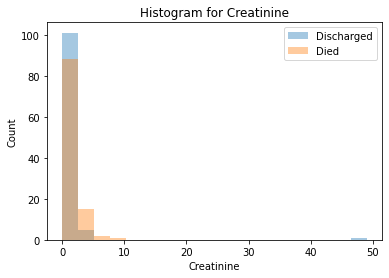

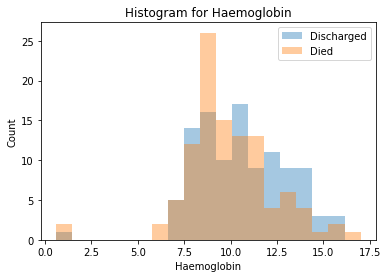

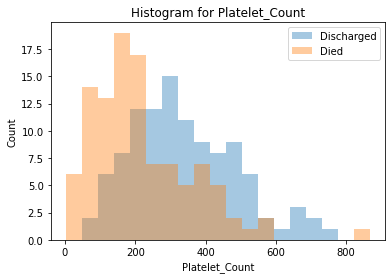

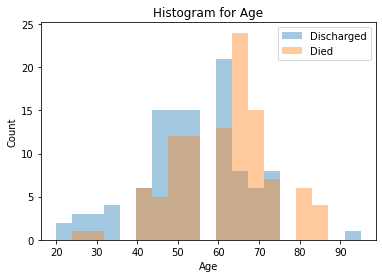

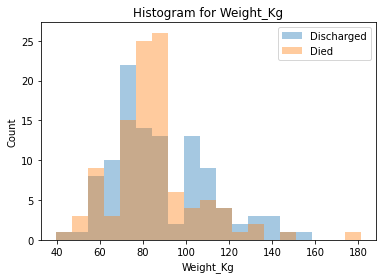

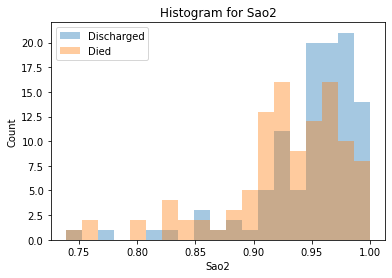

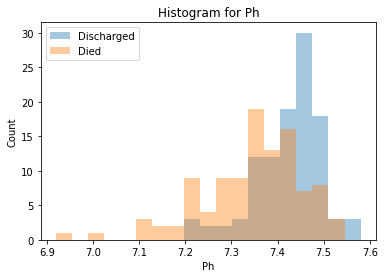

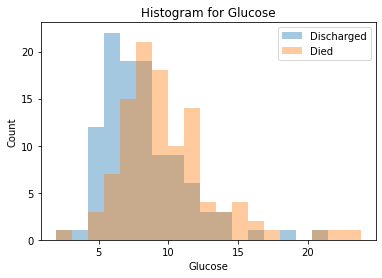

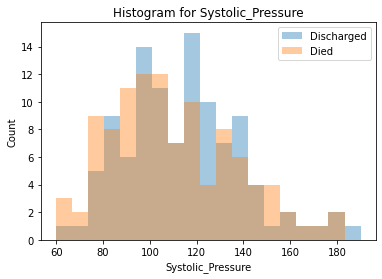

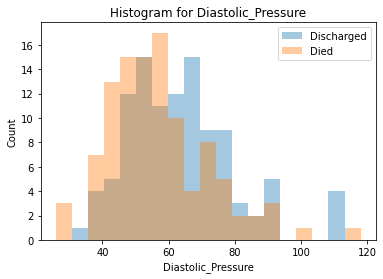

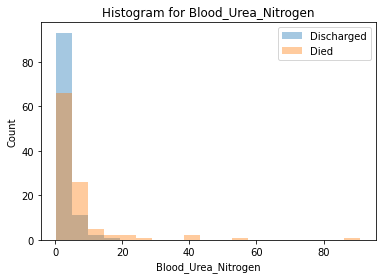

In [229]:
for col in X_cols:
    plot_feature(col)

### Histogram of Outcomes for each day

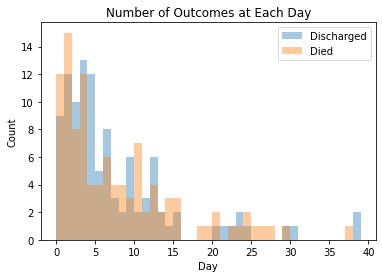

In [230]:
died = []
discharged = []

for index, point in enumerate(lst_train):
    if len(point) - 1 > 40:
        continue
        
    if Y_train[index]:
        died.append(len(point) - 1)
    else:
        discharged.append(len(point) - 1)
    
sns.distplot(discharged, kde=False, bins=range(40), label="Discharged")
fig = sns.distplot(died, kde=False, bins=range(40), label="Died")
plt.title('Number of Outcomes at Each Day')
plt.ylabel('Count')
plt.xlabel('Day')
plt.legend()
plt.show(fig)

### Correlation matrix

<AxesSubplot:>

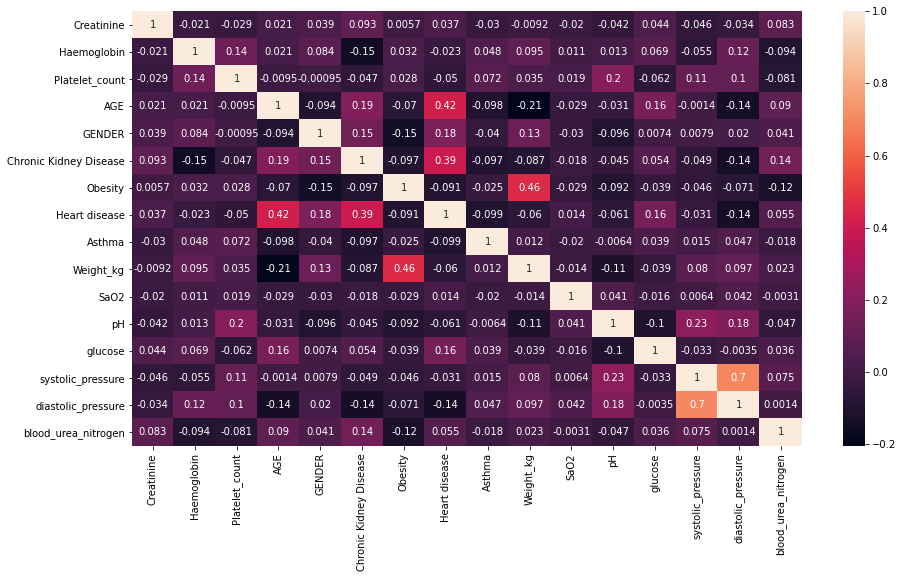

In [231]:
corrMatrix = df[X_cols].corr()

plt.figure(figsize=(15,8))
sns.heatmap(corrMatrix, annot=True)

### Create Model

Why 128 units?
Hypermarater search?
TODO

In [232]:
# units - dimensionality of output space from LSTM
lstm_units = 128

In [233]:
# load model
model_name = 'model_name'
model = keras.models.load_model(model_name)

In [234]:
model.summary()

Model: "functional_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_58 (InputLayer)           [(None, None, 16)]   0                                            
__________________________________________________________________________________________________
masking_19 (Masking)            (None, None, 16)     0           input_58[0][0]                   
__________________________________________________________________________________________________
input_59 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_60 (InputLayer)           [(None, 128)]        0                                            
______________________________________________________________________________________

In [235]:
def model_predict(x, h=None, c=None, state=False):
    """Wrapper function for running model predictions. 
    
    h: Input to the model, corresponds with `feedin_previous_output`.
        Set to None for default initialization
        
    c: Input to the model, corresponds with `feedin_cell_state`.
        Set to None for default initialization
        
    state: If True, return the state from the model. Otherwise, just return output.
    
    Returns: model output
    """
    
    if h is None:
        h = np.zeros((len(x), lstm_units))
        
    if c is None:
        c = np.zeros((len(x), lstm_units))

    if state:
        return model.predict([x, h, c])
    return model.predict([x, h, c])[0]

def model_evaluate(x, y):
    """Wrapper function to evaluate model accuracy on x and y. Returns accuracy."""
    
    return model.evaluate(x=[x, np.zeros((len(x), lstm_units)), np.zeros((len(x), lstm_units))],
                          y=y, verbose=False)[2]

In [236]:
model.fit(x=[X_train, np.zeros((len(X_train), 128)), np.zeros((len(X_train), 128))],
          y=Y_train, class_weight=class_weight, epochs=30)

Epoch 1/30
7/7 [==============================] - 0s 19ms/step - loss: 0.8533 - dense_19_loss: 0.8533 - dense_19_acc: 0.4742 - lambda_58_acc: 0.0000e+00 - lambda_59_acc: 0.0000e+00
Epoch 2/30
7/7 [==============================] - 0s 18ms/step - loss: 0.7490 - dense_19_loss: 0.7490 - dense_19_acc: 0.4930 - lambda_58_acc: 0.0000e+00 - lambda_59_acc: 0.0000e+00
Epoch 3/30
7/7 [==============================] - 0s 19ms/step - loss: 0.6744 - dense_19_loss: 0.6744 - dense_19_acc: 0.5493 - lambda_58_acc: 0.0000e+00 - lambda_59_acc: 0.0000e+00
Epoch 4/30
7/7 [==============================] - 0s 18ms/step - loss: 0.6305 - dense_19_loss: 0.6305 - dense_19_acc: 0.6338 - lambda_58_acc: 0.0000e+00 - lambda_59_acc: 0.0000e+00
Epoch 5/30
7/7 [==============================] - 0s 18ms/step - loss: 0.6024 - dense_19_loss: 0.6024 - dense_19_acc: 0.6854 - lambda_58_acc: 0.0000e+00 - lambda_59_acc: 0.0000e+00
Epoch 6/30
7/7 [==============================] - 0s 19ms/step - loss: 0.5819 - dense_19_loss: 

In [237]:
model_evaluate(X_train, Y_train)

0.8403756022453308

In [238]:
model_evaluate(X_test, Y_test)

0.6888889074325562

In [286]:
%%javascript
// Retrain model
Jupyter.notebook.execute_cells([29,30,31,32,33,34,35,36])

<IPython.core.display.Javascript object>

In [69]:
# save model, remember to set a name
# model_name = os.path.join('saved_models', 'hmm')
# model.save('model_name', overwrite=False)

INFO:tensorflow:Assets written to: saved_models/BinaryDeath_random_873\assets


In [239]:
# AUC
res = model_predict(x=X_test)[:,0]
argsort = np.argsort(res)

roc_auc_score(Y_test[argsort], res[argsort])

0.7454999999999999

In [240]:
print(classification_report(Y_test[argsort], np.rint(res[argsort]).astype(int)))

              precision    recall  f1-score   support

         0.0       0.76      0.64      0.70        50
         1.0       0.62      0.75      0.68        40

    accuracy                           0.69        90
   macro avg       0.69      0.70      0.69        90
weighted avg       0.70      0.69      0.69        90



how good is it?:
compare random forest with only admission data
can also do LSTM for this

## Missclassified results

In [241]:
argsort = np.argsort(Y_test)
Y_test[argsort[::-1]]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [242]:
preds = model_predict(X_test)
np.rint(preds).astype(int)[:,0][argsort[::-1]]

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0])

# Plot accuracy vs increasing sequence length (from 0)

<AxesSubplot:>

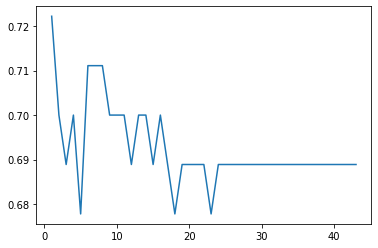

In [243]:
maxseqlen_test = max(len(lst) for lst in lst_test)
x = list(range(1,maxseqlen_test))
y = [model_evaluate(X_test[:,:a,:], Y_test) for a in x]

sns.lineplot(x=x, y=y)

# Plot accuracy vs increasing sequence length (from end)
Is the model using anything more than the previous days data to predict death? 
If the accuracy increases when using more data from the end we can assume so.

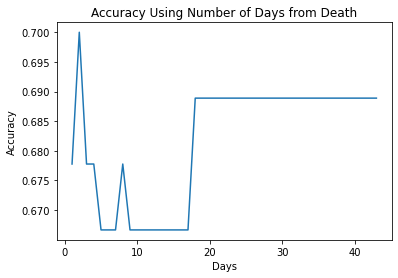

In [244]:
x = list(range(1,maxseqlen_test))
y = []

arr = np.zeros(X_test.shape)

for length in x:
    for index, point in enumerate(lst_test):
        r = np.array(point[::-1][:length][::-1])
        arr[index, :r.shape[0], :X_test.shape[2]] = r

    y.append(model_evaluate(arr, Y_test))
    
fig = sns.lineplot(x=x, y=y)
plt.title('Accuracy Using Number of Days from Death')
plt.ylabel('Accuracy')
plt.xlabel('Days')
plt.show(fig)

# Plot accuracy vs decreasing sequence length (from end)
E.g. accuracy without last 1,2,3,... days

Baseline represents accuracy from always predicting discharged

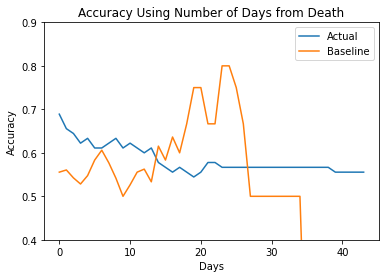

In [245]:
x = list(range(maxseqlen_test))
y = []
z = []

for length in x:
    arr = np.zeros(X_test.shape)
    discharged, total = 0, 0
    
    for index, point in enumerate(lst_test):
        r = point
        if len(point) > length:
            if length > 0:
                r = r[:-length]
                
            if Y_test[index] == 0:
                discharged += 1
            total += 1
            
            arr[index, :r.shape[0], :X_test.shape[2]] = r

    y.append(model_evaluate(arr, Y_test))
    z.append(discharged / total)
    
fig = sns.lineplot(x=x, y=y, label='Actual')
fig = sns.lineplot(x=x, y=z, label='Baseline')
plt.title('Accuracy Using Number of Days from Death')
plt.ylabel('Accuracy')
plt.xlabel('Days')
plt.ylim(0.4, 0.9)
plt.show(fig)

# Misclassified stats

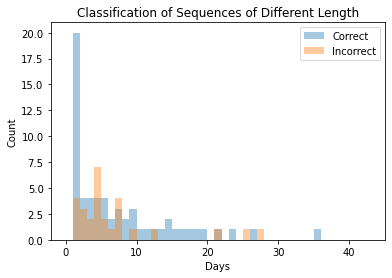

In [246]:
correct = []
incorrect = []

for index in range(len(lst_test)):
    result = model_predict(np.array([lst_test[index]]))[0][0]

    if Y_test[index] == round(result):
        correct.append(len(lst_test[index]))
    else:
        incorrect.append(len(lst_test[index]))

sns.distplot(correct, kde=False, bins=range(max(*correct, *incorrect)), label="Correct")
fig = sns.distplot(incorrect, kde=False, bins=range(max(*correct, *incorrect)), label="Incorrect")
plt.legend()
plt.title('Classification of Sequences of Different Length')
plt.ylabel('Count')
plt.xlabel('Days')
plt.legend()
plt.show(fig)

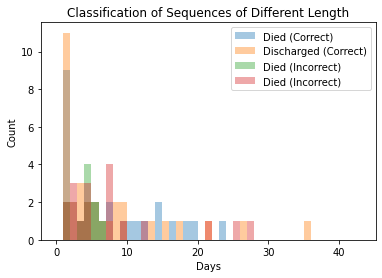

In [247]:
correct = {'Died':[], 'Discharged':[]}
incorrect = {'Died':[], 'Discharged':[]}

for index in range(len(lst_test)):
    result = model_predict(np.array([lst_test[index]]))[0][0]

    if Y_test[index] == round(result):
        if Y_test[index] == 0:
            correct['Discharged'].append(len(lst_test[index]))
        else:
            correct['Died'].append(len(lst_test[index]))
    else:
        if Y_test[index] == 0:
            incorrect['Discharged'].append(len(lst_test[index]))
        else:
            incorrect['Died'].append(len(lst_test[index]))
            
bins = range(max([y for x in list(correct.values()) + list(incorrect.values()) for y in x]))
            
sns.distplot(correct['Died'], kde=False, bins=bins, label="Died (Correct)")
sns.distplot(correct['Discharged'], kde=False, bins=bins, label="Discharged (Correct)")
sns.distplot(incorrect['Died'], kde=False, bins=bins, label="Died (Incorrect)")
fig = sns.distplot(incorrect['Discharged'], kde=False, bins=bins, label="Died (Incorrect)")
plt.legend()
plt.title('Classification of Sequences of Different Length')
plt.ylabel('Count')
plt.xlabel('Days')
plt.legend()
plt.show(fig)

# SHAP

Import a local version of shap in order to change a default setting for force plots. This is optional.

In [248]:
sys.path.append(os.path.join('../..', 'shap'))
import shap as shap

shap.initjs()

In [249]:
def predict(X, **kwargs):
    X = X.reshape((-1,1,len(X_cols)))
    return model_predict(X).flatten()

In [250]:
all_data_summary = shap.kmeans(df_test[X_cols], 10)

In [251]:
input_data = df_test[X_cols]

In [252]:
%%time
explainer = shap.KernelExplainer(predict, all_data_summary)
shap_values = explainer.shap_values(input_data)


CPU times: user 22min 59s, sys: 4min 14s, total: 27min 13s
Wall time: 9min 23s


In [117]:
# save explanations to save time rerunning everything
try:
    os.makedirs(os.path.join(model_name, 'shap_values'))
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
        
pickle.dump(explainer, open(os.path.join(model_name, 'shap_values', 'explainer.pkl'), "wb"))
pickle.dump(shap_values, open(os.path.join(model_name, 'shap_values', 'shap_values.pkl'), "wb"))

In [33]:
# load explanations
explainer = pickle.load(open(os.path.join(model_name, 'shap_values', 'explainer.pkl'), "rb"))
shap_values = pickle.load(open(os.path.join(model_name, 'shap_values', 'shap_values.pkl'), "rb"))

High SHAP values -> influenced the model towards death. E.g. High age and heart rate is associated with dying.

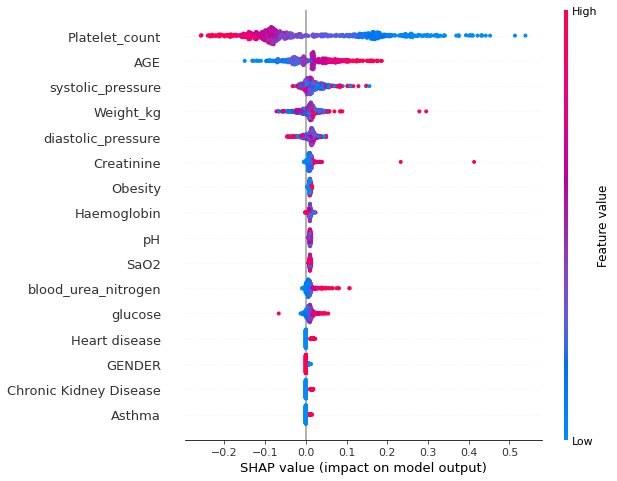

In [253]:
shap.summary_plot(shap_values, input_data)

The below shows a plot of age against the SHAP value. We can see that the age of around 65 has no effect on the model, in this case it is the average value. We also see how a high age always increases death chance, and a low age always decreases. However, this is not always the case. e.g. Heart rate can be too low or too high which will increase the shap value.

Bonus - try changing internaction_index

In [254]:
df_test['AGE'].mean()

57.757009345794394

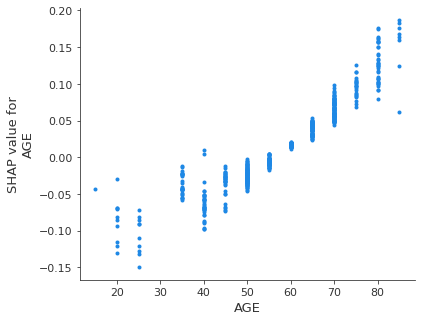

In [255]:
shap.dependence_plot('AGE', shap_values, features=input_data, interaction_index=None)

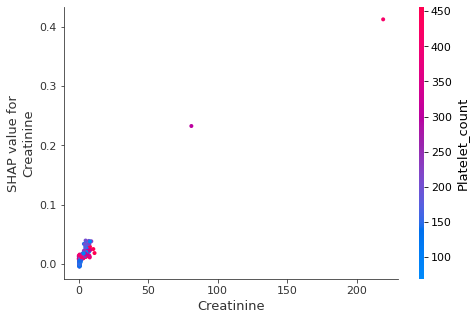

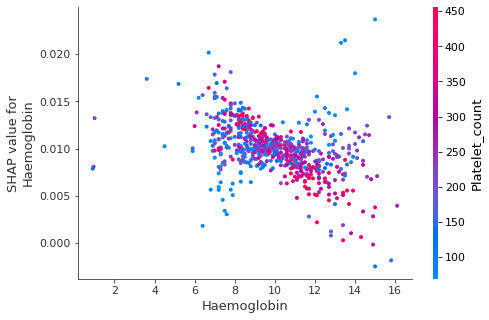

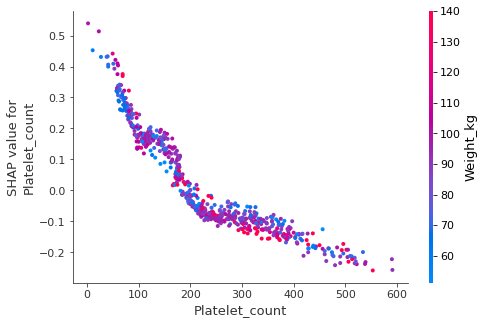

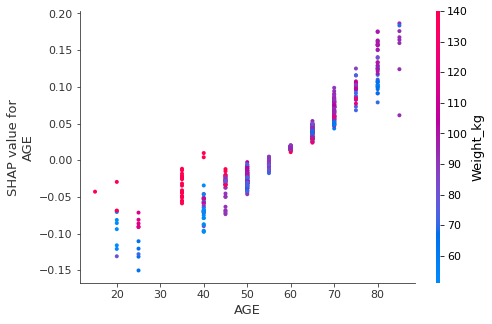

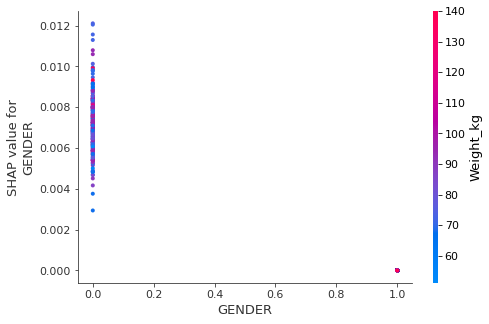

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


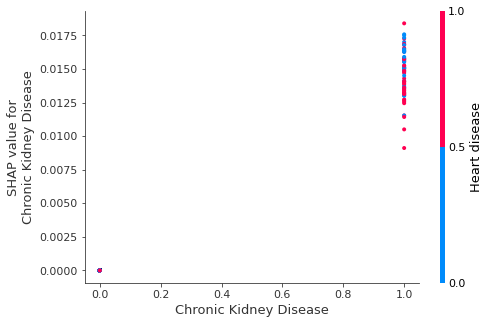

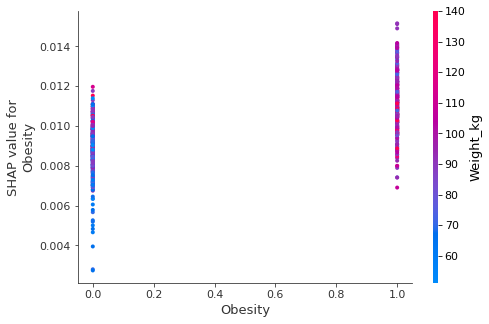

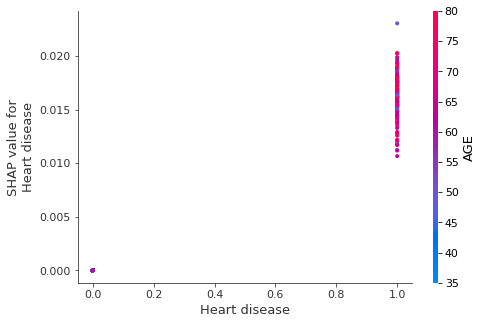

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


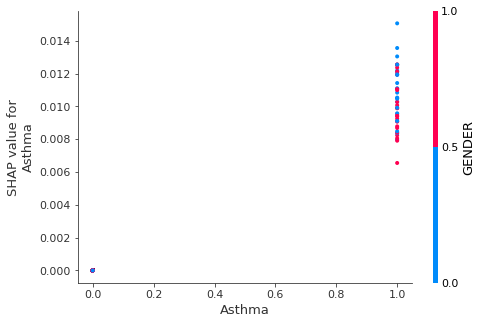

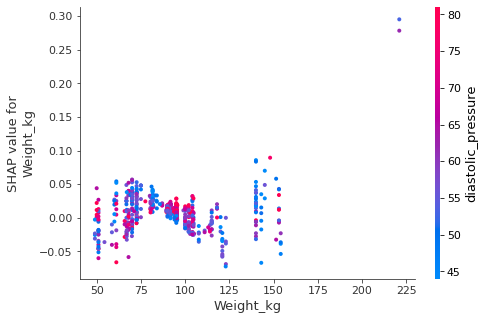

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


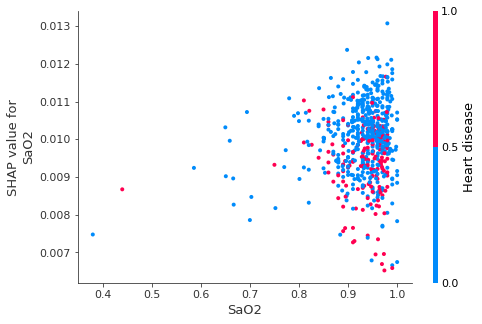

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


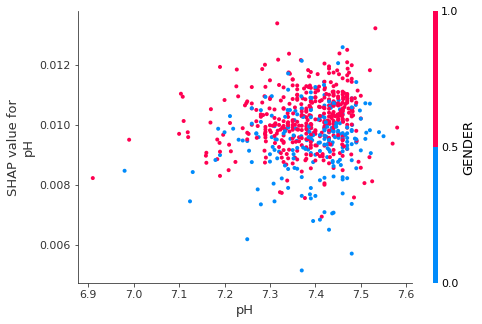

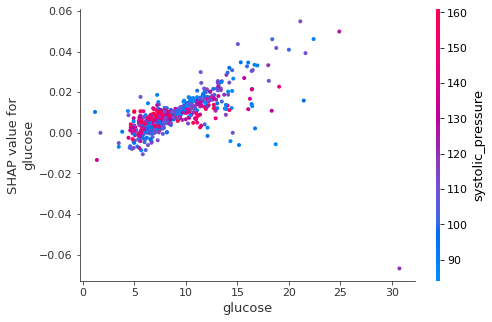

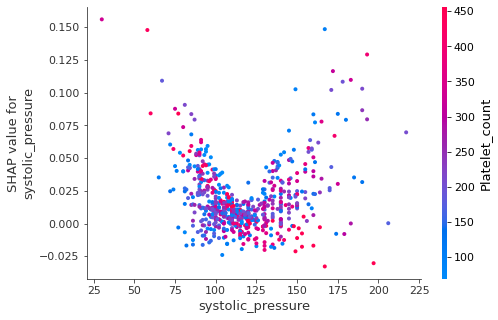

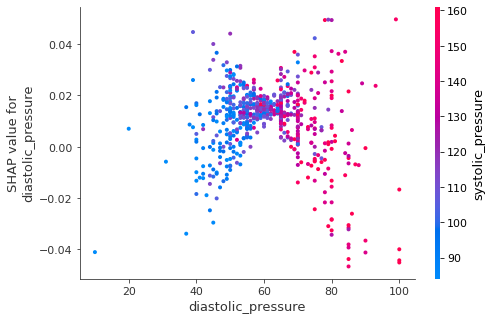

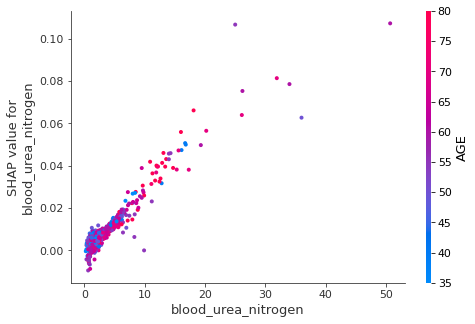

In [257]:
for feature in X_cols:
    shap.dependence_plot(feature, shap_values, features=input_data)    

## Look at evolution for an entire sequence
We can use a force plot to see how the SHAP scores change through a patients stay.

However, it's important to note that the model from SHAP only uses data from a single day.

In [258]:
seq = [0] + list(map(len, lst_test))
for i in range(len(seq)):
    if i != 0:
        seq[i] += seq[i-1]

longest_sequences_index = list(reversed(np.argsort([len(x) for x in lst_test])))

In [259]:
index = longest_sequences_index[18]

sl = slice(seq[index], seq[index+1])
print(f"Sequence length: {seq[index+1] - seq[index]}")
print(f"Predicted {preds[index,0]}, Actual {Y_test[index]}")
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

Sequence length: 11
Predicted 0.9280307292938232, Actual 1.0


In [260]:
index = 8
sl = slice(index, index+1)
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

In [261]:
index = 12
sl = slice(index, index+1)
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

In [262]:
shap.force_plot(explainer.expected_value, shap_values, input_data)

# Proper SHAP LSTM Design

This article highlights the problem with doing SHAP the way I have above, as does the `Model Predictions For Sequence` graph above. There should be no difference between the force plot from SHAP and the actual sequence predictions, however it is clear there is a difference.

https://towardsdatascience.com/interpreting-recurrent-neural-networks-on-multivariate-time-series-ebec0edb8f5a

The solution is to use a fundamental property of LSTMs - the hidden states. The solution still involves inputting a single time step at a time into SHAP. However, we now store the previous LSTM hidden states and pass them on to the next time step in the sequence. This will require some changes to the SHAP library.

In order to do this, I have made my model take two extra inputs for the hidden states and the model also gives two extra outputs for the hidden states.

For a reference implementation in pytorch, see https://github.com/AndreCNF/shap (https://github.com/slundberg/shap/compare/master...AndreCNF:master).


To tell SHAP how the sequences are related, we pass in an `association` array. This is a mapping from index in sequence to sequence id. In this case, it's just the HADM_ID slice in the dataframe.

In [264]:
def state_predict(X, internal_state=None):
    """
    internal_state: list of internal states. should be of the form [h, c]
    
    Returns [output, h, c]
    """
    if isinstance(X, (pd.DataFrame, pd.Series)):
        X = X.values
    X = X.reshape((-1,1,len(X_cols)))
    
    if internal_state:
        h,c = internal_state
        o, nh, nc = model_predict(X, h=h, c=c, state=True)
        return o.flatten(), nh, nc

    o, nh, nc = model_predict(X, state=True)
    return o.flatten(), nh, nc

In [265]:
input_data = df_test[X_cols]
state_explainer = shap.KernelExplainer(state_predict, all_data_summary)
state_shap_values = state_explainer.shap_values(input_data, association=df_test['HADM_ID'])

In [121]:
# save explanations 
pickle.dump(state_explainer, open(os.path.join(model_name, 'shap_values', 'state_explainer.pkl'), "wb"))
pickle.dump(state_shap_values, open(os.path.join(model_name, 'shap_values', 'state_shap_values.pkl'), "wb"))

In [50]:
# load explanations
state_explainer = pickle.load(open(os.path.join(model_name, 'shap_values', 'state_explainer.pkl'), "rb"))
state_shap_values = pickle.load(open(os.path.join(model_name, 'shap_values', 'state_shap_values.pkl'), "rb"))

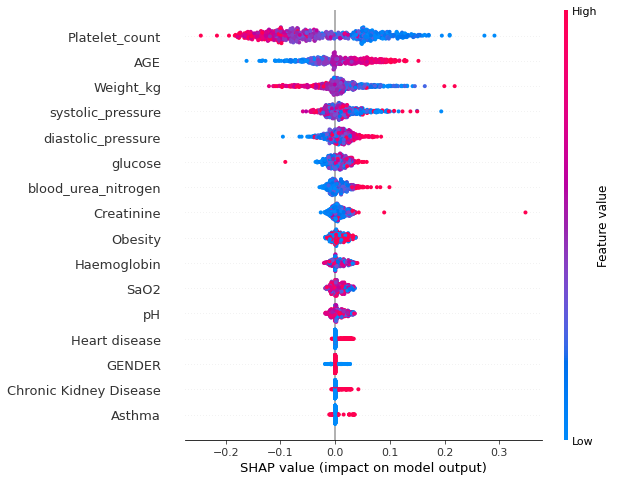

In [266]:
shap.summary_plot(state_shap_values, input_data)

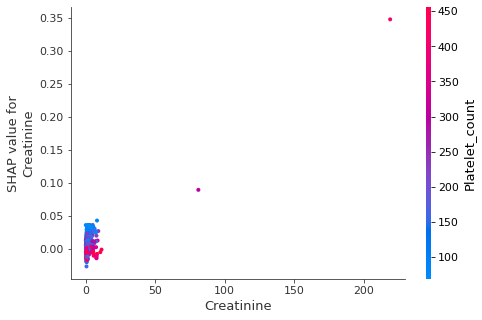

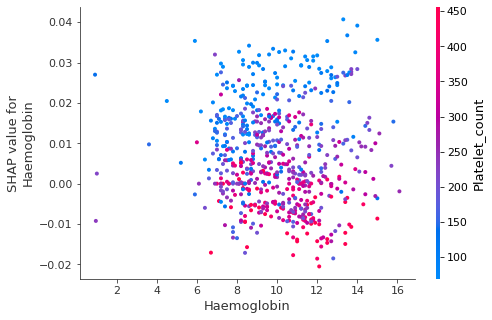

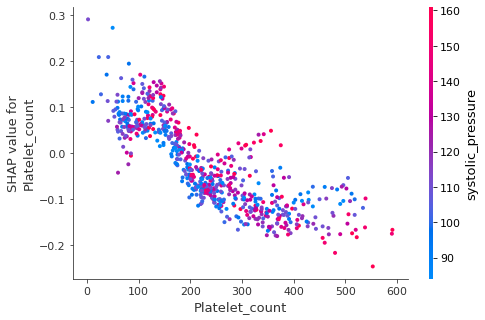

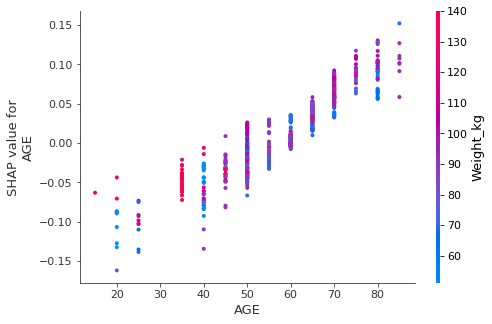

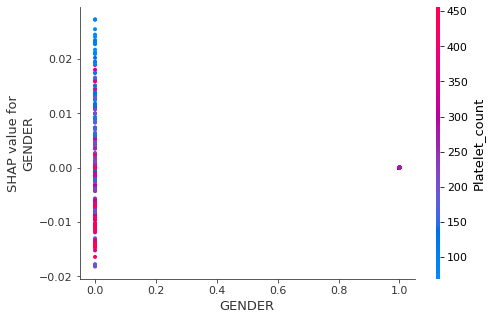

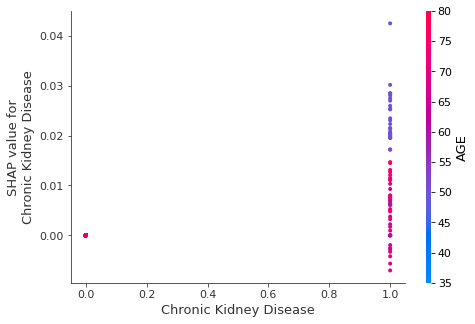

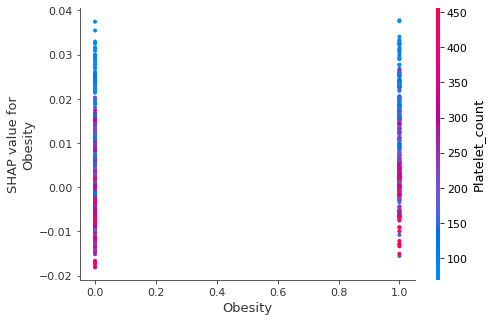

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


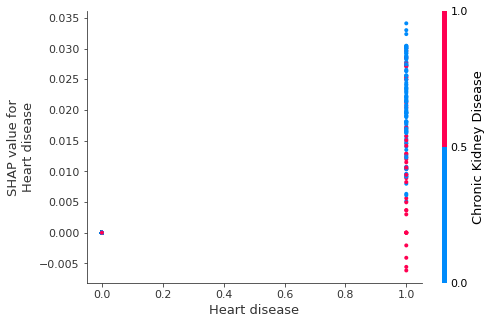

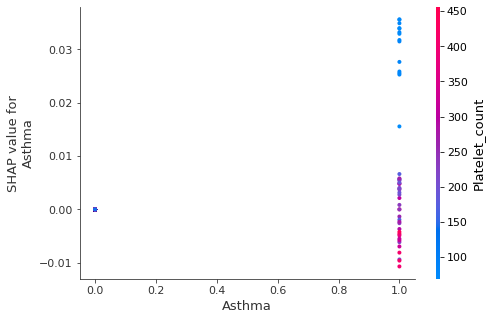

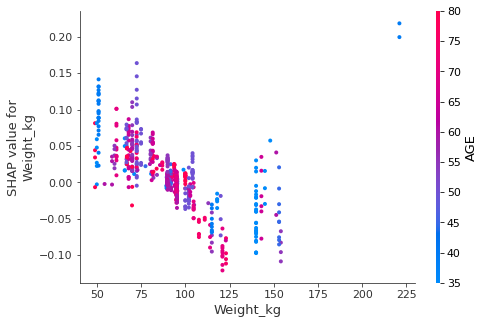

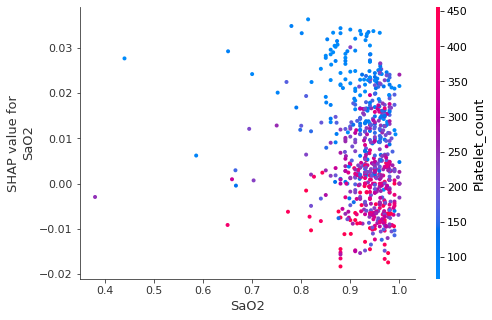

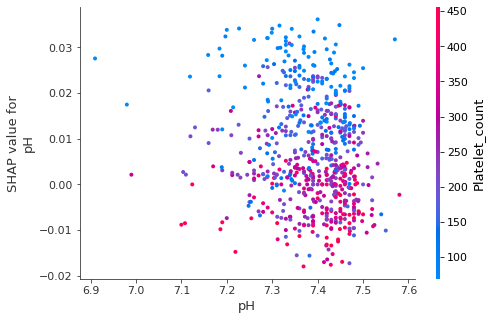

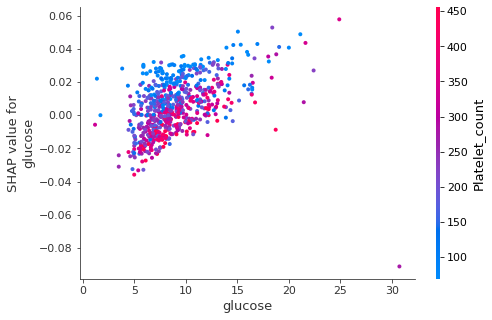

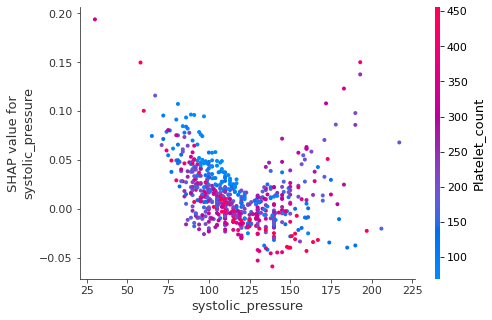

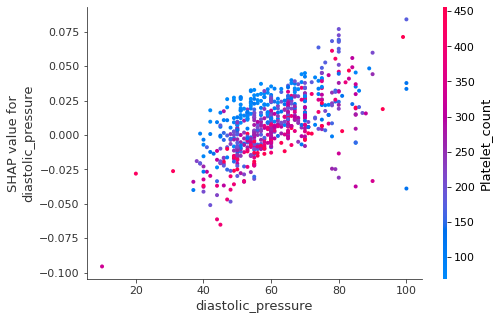

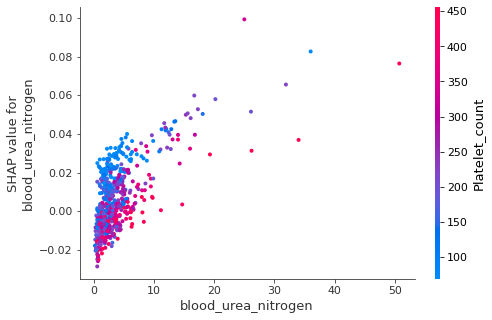

In [267]:
for feature in X_cols:
    shap.dependence_plot(feature, state_shap_values, features=input_data)    

In [268]:
index = longest_sequences_index[2]

sl = slice(seq[index], seq[index+1])
print(f"Sequence length: {seq[index+1] - seq[index]}")
print(f"Predicted {preds[index,0]}, Actual {Y_test[index]}")
shap.force_plot(state_explainer.expected_value, state_shap_values[sl], input_data[sl])

Sequence length: 27
Predicted 0.6344659328460693, Actual 0.0


In [269]:
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

We wish to see what difference the single day data makes on the models confidence throughout the stay.

We can see that the dashed lines overlap the non dashed lines

Text(0.5, 0, 'Days')

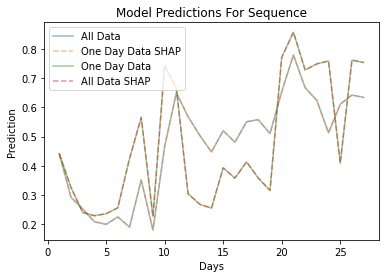

In [270]:
my_arr = lst_test[index]
x = range(1,len(my_arr)+1)

all_data = [my_arr[:i].reshape((1,-1,len(X_cols))) for i in x]
single_day = [my_arr[i-1:i].reshape((1,-1,len(X_cols))) for i in x]

all_data = np.array([model_predict(x) for x in all_data]).reshape(-1)
single_day = np.array([model_predict(x) for x in single_day]).reshape(-1)

sns.lineplot(x=x, y=all_data, alpha=0.5, label="All Data")
sns.lineplot(x=x, y=state_shap_values[sl].sum(axis=1) + state_explainer.expected_value,
                  alpha=0.5, label="One Day Data SHAP")
sns.lineplot(x=x, y=single_day, alpha=0.5, label="One Day Data")
ax = sns.lineplot(x=x, y=shap_values[sl].sum(axis=1) + explainer.expected_value,
                  alpha=0.5, label="All Data SHAP")
ax.lines[1].set_linestyle("--")
ax.lines[3].set_linestyle("--")
plt.legend()
plt.title('Model Predictions For Sequence')
plt.ylabel('Prediction')
plt.xlabel('Days')